### Basic Imports

In [1]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

### Image Loading Testing

In [2]:
sample_img = tf.io.read_file('../data/ready/combined/1.png')
sample_img = tf.io.decode_png(sample_img)
print(sample_img.shape)

(512, 1024, 3)


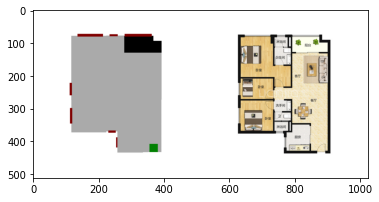

In [3]:
plt.figure()
plt.imshow(sample_img)

### Loading and cropping the images

In [4]:
def load(image_file):

    image = tf.io.read_file(image_file)
    image = tf.io.decode_png(image)

    w = tf.shape(image)[1]
    w = w // 2

    real_image = image[:, w:, :]
    input_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

### Testing and plotting load function

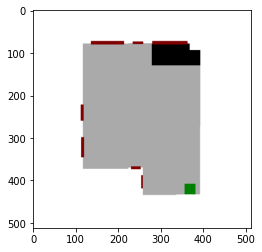

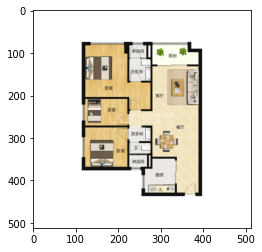

In [5]:
inp, re = load('../data/ready/combined/1.png')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

### Defining Some Global variables

In [6]:
BUFFER_SIZE = 925
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512

### Preprocessing the dataset

Resizing images to a specified size suitable to the Model Architecture

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

Applying random cropping on the images as recommended in the pix to pix paper

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

Normalizing the images in order to keep the calculations small enough. (0,255) -> (-1,1)

In [9]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

Random jitter function which resizes, applies random crops as well as flipping images based on a 50% probablity

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 542, 542)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

Testing the random jitter and plotting respective images

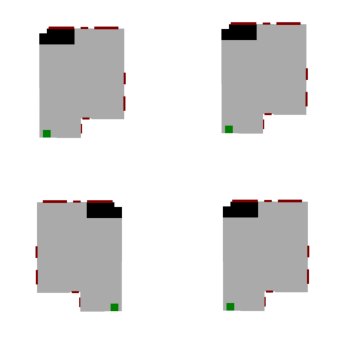

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()


### Loading & Preprocessing the Dataset

In [12]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files('../data/ready/combined/*.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

len(train_dataset)


925

### **Defining Generator Arcitecture**

In [14]:
OUTPUT_CHANNELS = 3

**Downsample Block Eg: (512,512) -> (256,256)**

In [15]:
def downsample(filters, size, apply_batchnorm = True):

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same', kernel_initializer=initializer, use_bias=False)
    )

    if apply_batchnorm:

        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [16]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)

(1, 256, 256, 3)


**Upsample Block Eg: (256,256) -> (512,512)**

In [17]:
def upsample(filters, size, apply_dropout = False):

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()

    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding='same', kernel_initializer=initializer, use_bias = False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


In [18]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


### Generator

In [19]:
def Generator():

    inputs = tf.keras.layers.Input(shape=[512,512,3])

    down_stack = [
        downsample(32, 4, apply_batchnorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
        upsample(32, 4),  # (batch_size, 512, 512, 64)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs

    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)



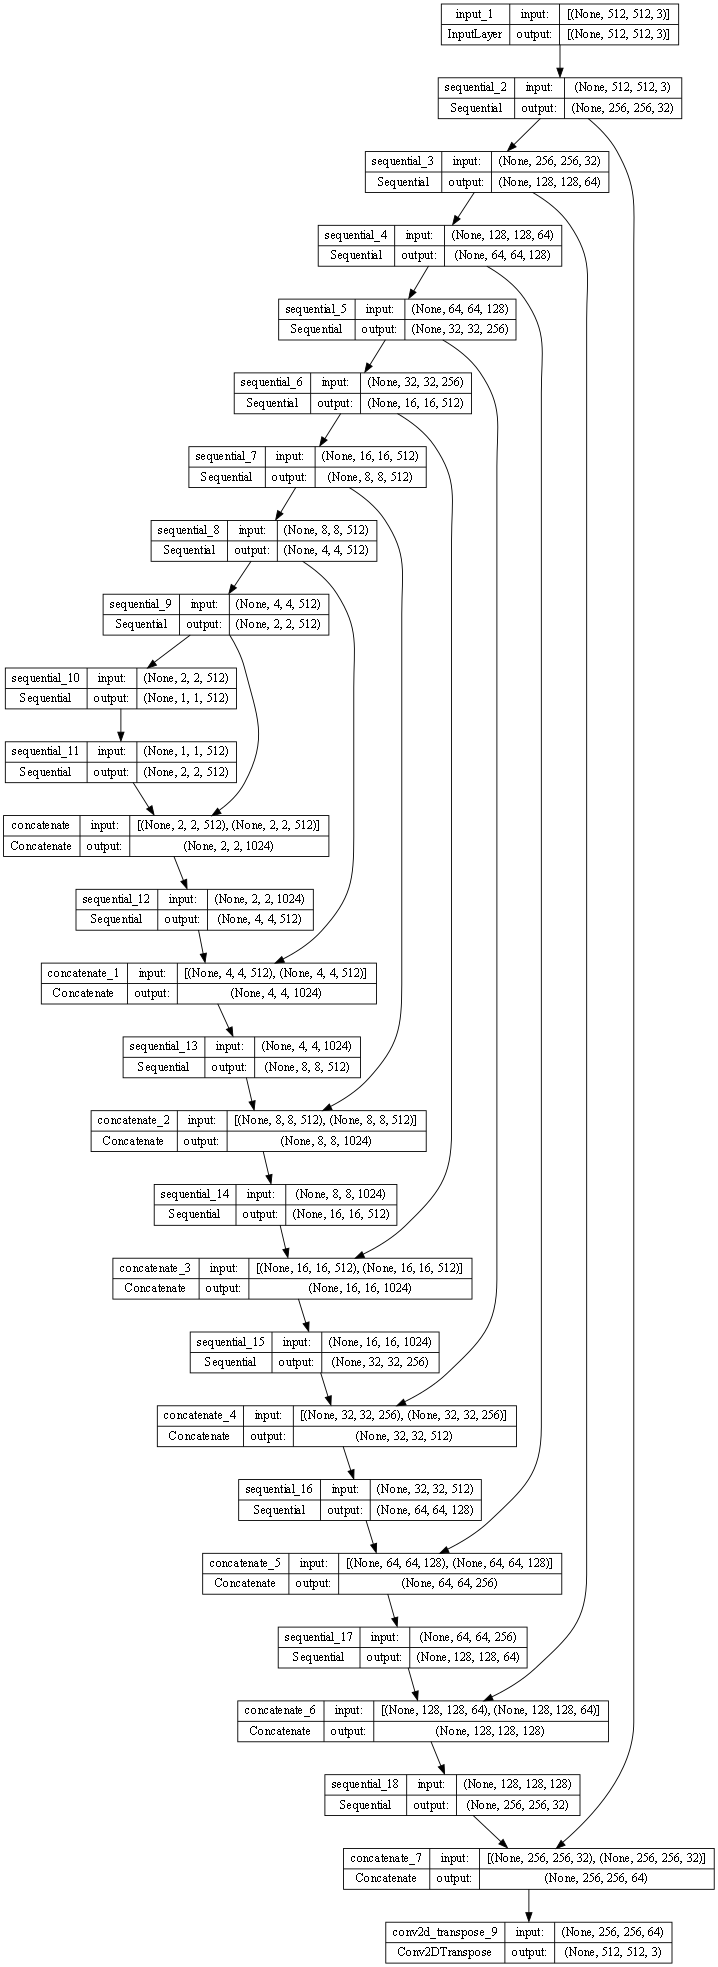

In [20]:
generator = Generator()
# print(generator.summary())
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


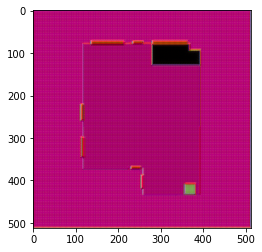

In [21]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Generator Loss Calculation

In [22]:
LAMBDA = 100

In [23]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [24]:
def generator_loss(disc_generated_output, gen_output, target):

    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### **Defining Discriminator Architecture**

In [25]:
def Discriminator():

    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape = [512, 512, 3], name = 'input_image')
    tar = tf.keras.layers.Input(shape = [512, 512, 3], name = 'target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down0 = downsample(32, 4, False)(x)
    down1 = downsample(64, 4)(down0)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                    kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

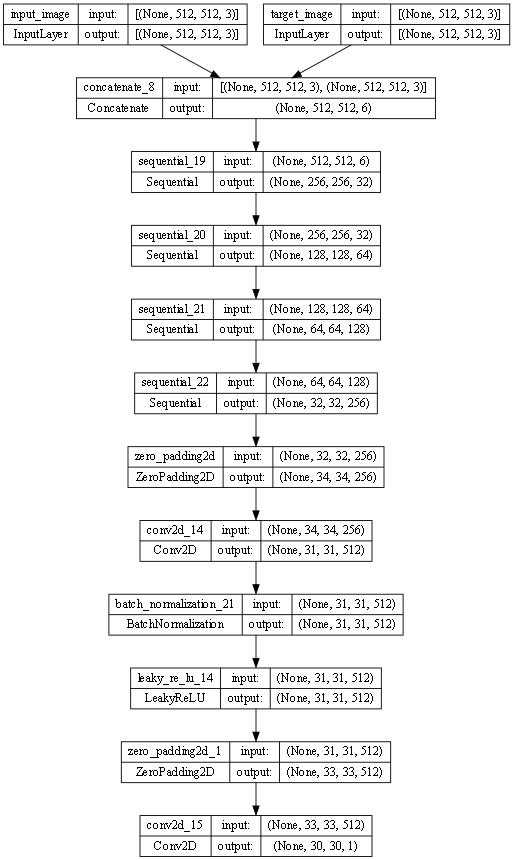

In [26]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

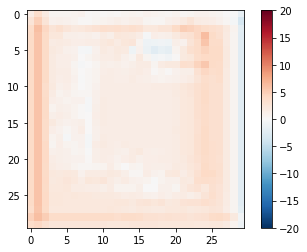

In [27]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Discriminator Loss Calculation

In [28]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### **Training**

Defining Optimizers

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Defining Checkpoints

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Helper Functions

In [31]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    # plt.axis('off')
  plt.show()

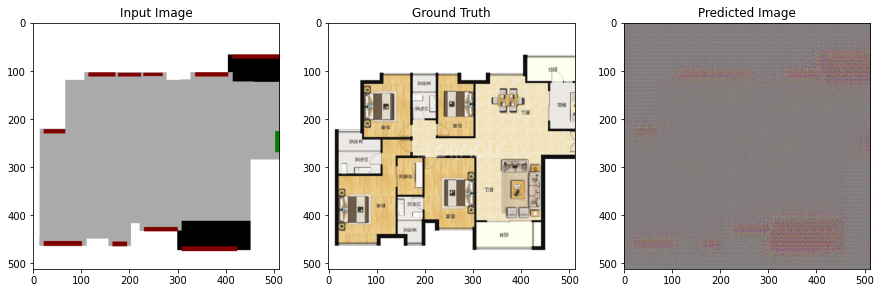

In [32]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

Defining Logs Directory to visualize later using tensorboard

In [33]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

### **Defining a single training step**

In [34]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

### Training Loop

In [35]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

#### Just to open a tensorboard window to live visualize the losses

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

## **Starting training**

Time taken for 1000 steps: 116.14 sec



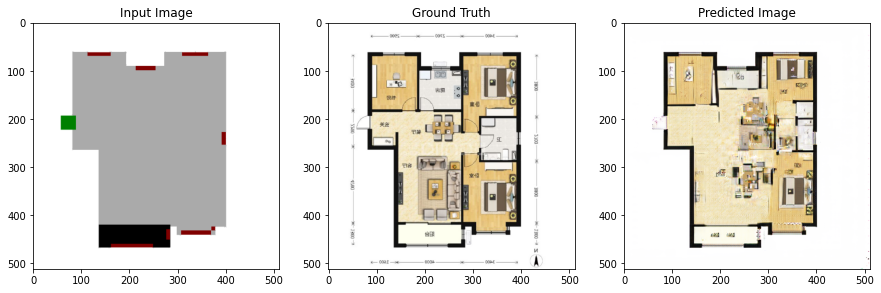

Step: 59k
....................................................................................................

In [57]:
fit(train_dataset, train_dataset, steps=60000)

In [72]:
checkpoint.restore(os.path.join(checkpoint_dir,'ckpt-24'))

In [74]:
generator.save('../saved_models/to_visualize/ckpt-24.h5')

In [37]:
def display_image_in_actual_size(im_data):

    dpi = plt.rcParams['figure.dpi']
    # im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data)

    plt.show()

(512, 512, 3)


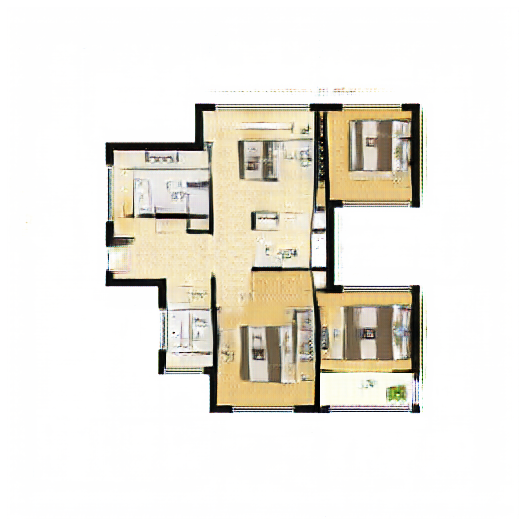

In [38]:
# test_dataset = tf.data.Dataset.list_files('../data/test_images/*.png')
# test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

# # test_dataset = test_dataset.shuffle(BUFFER_SIZE)
# # test_dataset = test_dataset.batch(BATCH_SIZE)

# len(test_dataset)
test_image = tf.io.read_file('../data/test_images/Sample_generator_3.png')
test_image = tf.io.decode_png(test_image)

test_image = tf.cast(test_image, tf.float32)

test_image = (test_image / 127.5) - 1
print(test_image.shape)

# test_image = tf.expand_dims(test_image, 0)

gen_image = generator(tf.expand_dims(test_image, 0), training= True)

# print(gen_image)

gen_image = (gen_image * 0.5) + 0.5

# plt.figure()
# plt.imshow(gen_image[0])  
display_image_in_actual_size(gen_image[0])
